<a href="https://colab.research.google.com/github/Leelddd/alchemy-101/blob/master/dlwp/5_3_using_a_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a pretrained convnet

## 5.3.1 Feature extraction

In [1]:
from keras.applications import VGG16

# include_top: include densely connected classifier or not
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 158s 3us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
___

Fast feature extraction without data augmentation

In [2]:
ls 

 dogcat/  'kaggle (1).json'   sample_data/


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'dogcat/base'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [0]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 835us/step - loss: 0.6530 - acc: 0.6435 - val_loss: 0.4420 - val_acc: 0.8280
Epoch 2/30
2000/2000 [==============================] - 1s 416us/step - loss: 0.4467 - acc: 0.7930 - val_loss: 0.3606 - val_acc: 0.8560
Epoch 3/30
2000/2000 [==============================] - 1s 416us/step - loss: 0.3600 - acc: 0.8415 - val_loss: 0.3233 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 1s 346us/step - loss: 0.3053 - acc: 0.8800 - val_loss: 0.2971 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 411us/step - loss: 0.2817 - acc: 0.8910 - val_loss: 0.2844 - val_acc: 0.8940
Epoch 6/30
2000/2000 [==============================] - 1s 339us/step - loss: 0.2597 - acc: 0.8920 - val_loss: 0.2701 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 1s 398us/step - loss: 0.2506 - a

In [0]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot(history, smooth=False):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc)+1)

    if smooth:
        plt.plot(epochs, smooth_curve(acc), 'b', label='Training acc')
        plt.plot(epochs, smooth_curve(val_acc), 'r', label='Validation acc')
    else:    
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.legend()
    plt.figure()

    if smooth:
        plt.plot(epochs, smooth_curve(loss), 'g', label='Training loss')
        plt.plot(epochs, smooth_curve(val_loss), 'y', label='Validation loss')
    else:
        plt.plot(epochs, loss, 'g', label='Training loss')
        plt.plot(epochs, val_loss, 'y', label='Validation loss')
    plt.legend()
    plt.show()

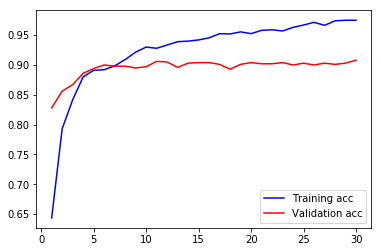

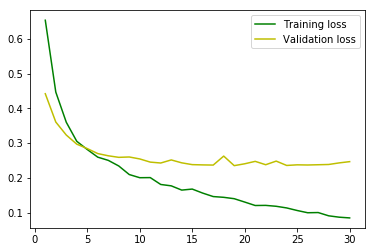

In [21]:
plot(history.history)

Feature extraction with data augmentation

In [37]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [38]:
len(model.trainable_weights)

30

In [0]:
# freeze the convolutional base
conv_base.trainable = False

In [40]:
len(model.trainable_weights)

4

In [42]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
 - 20s - loss: 0.2890 - acc: 0.8810 - val_loss: 0.2561 - val_acc: 0.8920
Epoch 2/100
 - 16s - loss: 0.2796 - acc: 0.8835 - val_loss: 0.2366 - val_acc: 0.9050
Epoch 3/100
 - 16s - loss: 0.2774 - acc: 0.8890 - val_loss: 0.2364 - val_acc: 0.9020
Epoch 4/100
 - 17s - loss: 0.2766 - acc: 0.8870 - val_loss: 0.2381 - val_acc: 0.9020
Epoch 5/100
 - 16s - loss: 0.2830 - acc: 0.8720 - val_loss: 0.2374 - val_acc: 0.9000
Epoch 6/100
 - 16s - loss: 0.2800 - acc: 0.8805 - val_loss: 0.2388 - val_acc: 0.9060
Epoch 7/100
 - 16s - loss: 0.2780 - acc: 0.8860 - val_loss: 0.2379 - val_acc: 0.9060
Epoch 8/100
 - 16s - loss: 0.2799 - acc: 0.8815 - val_loss: 0.2439 - val_acc: 0.9030
Epoch 9/100
 - 17s - loss: 0.2860 - acc: 0.8780 - val_loss: 0.2352 - val_acc: 0.9090
Epoch 10/100
 - 17s - loss: 0.2768 - acc: 0.8760 - val_loss: 0.2352 - val_acc: 0.9050
Epoch 11/100
 - 16s - loss: 0.2743 - acc: 0.8795 - val_loss: 0.23

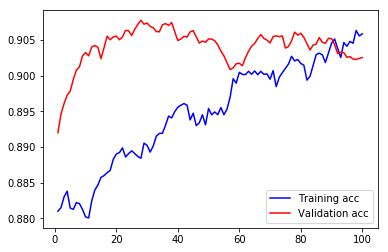

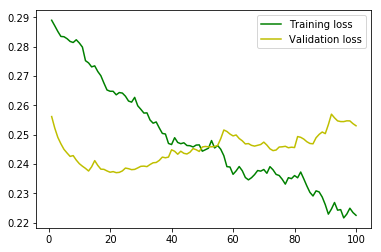

In [53]:
plot(history.history, True)

## 5.3.2 Fine-tuning

In [45]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

fine_history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
)

Epoch 1/30
100/100 [==============================] - 20s 198ms/step - loss: 0.1818 - acc: 0.9235 - val_loss: 0.2262 - val_acc: 0.9250
Epoch 2/30
100/100 [==============================] - 18s 176ms/step - loss: 0.1758 - acc: 0.9225 - val_loss: 0.2419 - val_acc: 0.9060
Epoch 3/30
100/100 [==============================] - 19s 192ms/step - loss: 0.1607 - acc: 0.9375 - val_loss: 0.2689 - val_acc: 0.9140
Epoch 4/30
100/100 [==============================] - 19s 190ms/step - loss: 0.1543 - acc: 0.9440 - val_loss: 0.2194 - val_acc: 0.9230
Epoch 5/30
100/100 [==============================] - 18s 176ms/step - loss: 0.1575 - acc: 0.9365 - val_loss: 0.2580 - val_acc: 0.9150
Epoch 6/30
100/100 [==============================] - 18s 179ms/step - loss: 0.1351 - acc: 0.9475 - val_loss: 0.2239 - val_acc: 0.9320
Epoch 7/30
100/100 [==============================] - 18s 180ms/step - loss: 0.1200 - acc: 0.9560 - val_loss: 0.2307 - val_acc: 0.9230
Epoch 8/30
100/100 [==============================] - 1

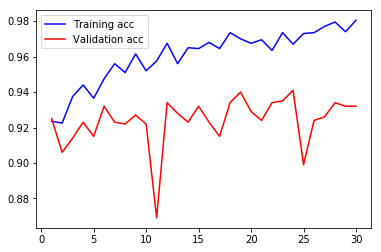

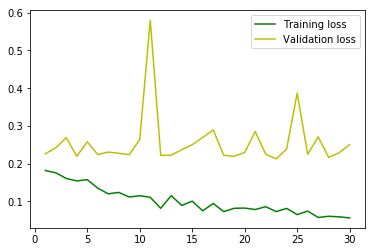

In [51]:
plot(fine_history.history)

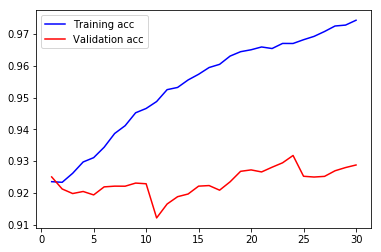

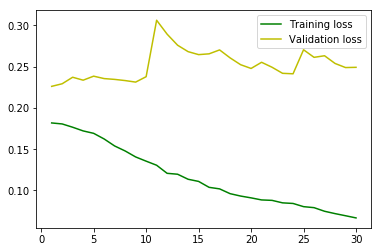

In [55]:
plot(fine_history.history, True)